# Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `6_area_calculations.ipynb` 
### Calculating the total areas of all the domains for the manuscript 

**Env**: I was using env `rasterio`, and everything was good except the scalebar addition Steven beautifully created.\
So, now I made a copy of `rasterio` called `rasterio_scalebar` which I then pip installed `matplotlib-scalebar`\
Now, working on the new UAS Linux Computer, I created a `cer_treatment` environment to use here.

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
# from matplotlib_scalebar.scalebar import ScaleBar

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

# import geopandas as gpd
# import rasterio as rio
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# import rioxarray
import rasterio
# import rasterstats
import scipy

# import plotly.express as px

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [2]:
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
pwd

'/home/cassie/python/repos/CER_treatment_manuscript'

In [4]:
# ds = xr.open_dataset('~/RAPID/cer_treatment_region_dataset_all_variables/cer_treatment_region_dataset_all_variables.nc') # Steven's path
# ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') # Cassie local path 
ds = xr.open_dataset('/home/cassie/data/cer_treatment_manuscript/cer_treatment_region_dataset_all_variables.nc') # Cassie remote path on new linux machine

---

In [5]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 21kB 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 11kB 2.111e+05 ... 2.097e+05
  * band                              (band) int32 4B 1
    spatial_ref                       int32 4B ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 14MB ...
    dce_rapid                         (band, y, x) float32 14MB ...
    giulia_dce_rapid                  (band, y, x) float32 14MB ...
    giulia_dce_ncalm                  (band, y, x) float32 14MB ...
    slope                             (band, y, x) float32 14MB ...
    aspect                            (band, y, x) float32 14MB ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 14MB ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 14MB ...

In [ ]:
# Constants 
# define path to save the figures to
# figure_path = "C:\\Users\\Lumbr\\OneDrive - UW\\Documents - mountainhydro\\People\\CassieLumbrazo\\EasternCascades\\Writing\\5_Manuscript\\2_PostDefense\\python_figures\\" # Cassie local path
figure_path = 'C:\\Users\\Lumbr\\OneDrive - University of Alaska\\UW_OneDrive\\EasternCascades\\Writing\\5_Manuscript\\2_PostDefense\\python_figures\\' # Cassie remote path

# colors
colorpre='darkslategray'
colorpos='royalblue'
# colorpos='mediumvioletred'

colorsouth = 'darkorange'
colornorth = 'darkblue'

colorcontrol = 'black'
colortreatment = 'saddlebrown'

## Calculate total area, for the polygons in the manuscript  (Table 1)

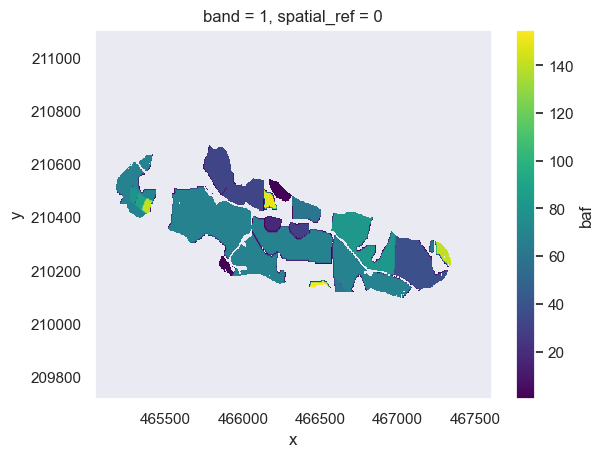

In [7]:
ds['baf'].plot()

Calculate the total area for the BAF polygon areas

In [8]:
# ALL
# Calculate the total area for all the BAF polygons 
all_polygons_total_area_m = ds['baf'].count().values
print("the total polygons area (m^2):", all_polygons_total_area_m.round(2))

# Convert to km2 
all_polygons_total_area_km = all_polygons_total_area_m / 1000000
print("the total polygons area (km^2):", all_polygons_total_area_km.round(2))

# Convert to acres 
all_polygons_total_area_acres = all_polygons_total_area_m / 4046.86
print("the total polygon area (acres):", all_polygons_total_area_acres.round(2))

print("--------------------------------")

# SOUTH ONLY
# Calculate for only the south side of the ridge 
south_polygons_total_area_m = ds['baf'].where(ds['baf_ridge'] == 1).count().values
print("the south polygons area (m^2):", south_polygons_total_area_m.round(2))

# Convert to km2
south_polygons_total_area_km = south_polygons_total_area_m / 1000000
print("the south polygons area (km^2):", south_polygons_total_area_km.round(2))

# Convert to acres 
south_polygons_total_area_acres = south_polygons_total_area_m / 4046.86
print("the south polygons area (acres):", south_polygons_total_area_acres.round(2))

print("--------------------------------")

# NORTH ONLY
# Calculate for only the north side of the ridge 
north_polygons_total_area_m = ds['baf'].where(ds['baf_ridge'] == -1).count().values
print("the north polygons area (m^2):", north_polygons_total_area_m.round(2))

# Convert to km2 
north_polygons_total_area_km = north_polygons_total_area_m / 1000000
print("the north polygons area (km^2):", north_polygons_total_area_km.round(2))

# Convert to acres 
north_polygons_total_area_acres = north_polygons_total_area_m / 4046.86
print("the north polygons area (acres):", north_polygons_total_area_acres.round(2))

the total polygons area (m^2): 433205
the total polygons area (km^2): 0.43
the total polygon area (acres): 107.05
--------------------------------
the south polygons area (m^2): 269025
the south polygons area (km^2): 0.27
the south polygons area (acres): 66.48
--------------------------------
the north polygons area (m^2): 164180
the north polygons area (km^2): 0.16
the north polygons area (acres): 40.57


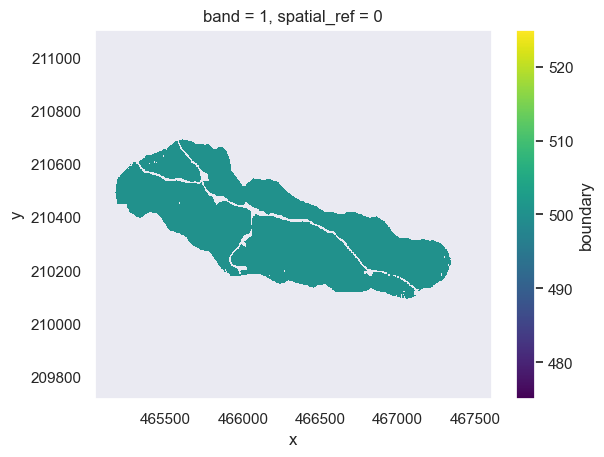

In [9]:
ds['boundary'].plot()

Calculate the total area for hte entire domain inside the boundary

In [10]:
print(1e6)
print(1000000)

1000000.0
1000000


In [11]:
# Calculate the total area for the entire domain inside boundary
boundary_total_area_m = ds['boundary'].count().values
print("boundary area (m^2):", boundary_total_area_m)

# Convert to km2 
boundary_total_area_km = boundary_total_area_m / 1e6
print("boundary area (km^2):", boundary_total_area_km)

# Convert to acres 
boundary_total_area_acres = boundary_total_area_m / 4046.86
print("boundary area (acres):", boundary_total_area_acres)

boundary area (m^2): 594938
boundary area (km^2): 0.594938
boundary area (acres): 147.0122514739823


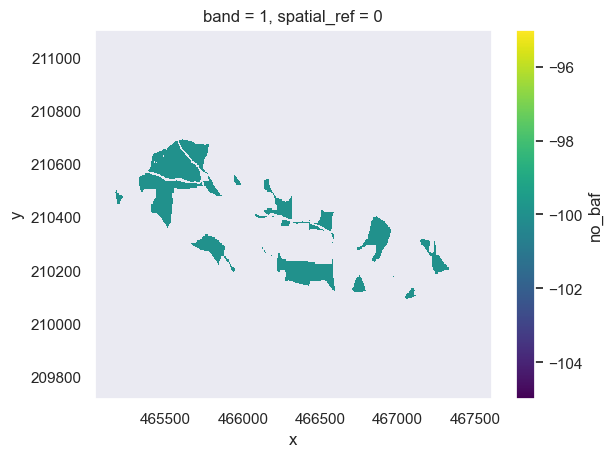

In [12]:
# First create a variable for the area which is not baf 
ds['no_baf'] = ds['baf'].fillna(-100)
ds['no_baf'] = ds['no_baf'].where(ds['no_baf'] < 0)

# now, make ds['no_baf'] nan everywhere ds['boundary'] is nan
ds['no_baf'] = ds['no_baf'].where(~np.isnan(ds['boundary']))
ds['no_baf'].plot()

Calculate the total area for the domain which is inside the boundary, but not in the BAF polygons

In [13]:
# Calculate the total area for the domain which is not the BAF polygons 
all_not_polygons_total_area_m = ds['no_baf'].count().values
print("the total non-polygon area (m2):", all_not_polygons_total_area_m.round(2))

# Conver to km2 
all_not_polygons_total_area_km2 = all_not_polygons_total_area_m/1000000
print("the total non-polygon area (km2):", all_not_polygons_total_area_km2.round(2))

# Convert to acres 
all_not_polygons_total_area_acres = all_not_polygons_total_area_m / 4046.86
print("the total non-polygon area (acres):", all_not_polygons_total_area_acres.round(2))

print("--------------------------------")

# Calculate the non-polygon area on the south side of the ridge only 
south_not_polygons_total_area_m = ds['no_baf'].where(ds['baf_ridge'] == 1).count().values
print("the south non-polygon area (m2):", south_not_polygons_total_area_m.round(2))

# Convert to km2
south_not_polygons_total_area_km2 = south_not_polygons_total_area_m / 1000000
print("the south non-polygon area (km2):", south_not_polygons_total_area_km2.round(2))

# Convert to acres
south_not_polygons_total_area_acres = south_not_polygons_total_area_m / 4046.86
print("the south non-polygon area (acres):", south_not_polygons_total_area_acres.round(2))

print("--------------------------------")

# Calculate the non-polygon area on the north side of the ridge only
north_not_polygons_total_area_m = ds['no_baf'].where(ds['baf_ridge'] == -1).count().values
print("the north non-polygon area (m2):", north_not_polygons_total_area_m.round(2))

# Convert to km2
north_not_polygons_total_area_km2 = north_not_polygons_total_area_m / 1000000
print("the north non-polygon area (km2):", north_not_polygons_total_area_km2.round(2))

# Convert to acres
north_not_polygons_total_area_acres = north_not_polygons_total_area_m / 4046.86
print("the north non-polygon area (acres):", north_not_polygons_total_area_acres.round(2))

the total non-polygon area (m2): 161733
the total non-polygon area (km2): 0.16
the total non-polygon area (acres): 39.97
--------------------------------
the south non-polygon area (m2): 96403
the south non-polygon area (km2): 0.1
the south non-polygon area (acres): 23.82
--------------------------------
the north non-polygon area (m2): 65330
the north non-polygon area (km2): 0.07
the north non-polygon area (acres): 16.14


Now, calculate the total area for each BAF polygon on each side of the ridge

In [14]:
# first, make all of the BAF polygons their own variable, to then get the area by polygons and aspect 
# south side BAF polygons
ds['baf_1_leavegap_s'] = ds['baf'].where((ds['baf'] == 1) & (ds['baf_ridge'] ==  1)) # leave gap has no BAF
ds['baf_17_s'] = ds['baf'].where((ds['baf'] == 17) & (ds['baf_ridge'] ==  1)) 
ds['baf_30_s'] = ds['baf'].where((ds['baf'] == 30) & (ds['baf_ridge'] ==  1))
ds['baf_60_s'] = ds['baf'].where((ds['baf'] == 60) & (ds['baf_ridge'] ==   1))
ds['baf_69_s'] = ds['baf'].where((ds['baf'] == 69) & (ds['baf_ridge'] ==   1))
ds['baf_80_s'] = ds['baf'].where((ds['baf'] == 80) & (ds['baf_ridge'] ==   1))
ds['baf_90_s'] = ds['baf'].where((ds['baf'] == 90) & (ds['baf_ridge'] ==   1))
ds['baf_140_s'] = ds['baf'].where((ds['baf'] == 140) & (ds['baf_ridge'] ==   1))
ds['baf_155_s'] = ds['baf'].where((ds['baf'] == 155) & (ds['baf_ridge'] ==   1))
ds['baf_2_leaveforest_s'] = ds['baf'].where((ds['baf'] == 2) & (ds['baf_ridge'] == 1)) # leave forest on south has no BAF, so it's 2

# north side BAF polygons
ds['baf_1_leavegap_n'] = ds['baf'].where((ds['baf'] == 1) & (ds['baf_ridge'] == -1)) # leave gap has no BAF 
ds['baf_32_n'] = ds['baf'].where((ds['baf'] == 32) & (ds['baf_ridge'] ==  -1))
ds['baf_38_n'] = ds['baf'].where((ds['baf'] == 38) & (ds['baf_ridge'] ==  -1))
ds['baf_60_n'] = ds['baf'].where((ds['baf'] == 60) & (ds['baf_ridge'] ==  -1))
ds['baf_82_n'] = ds['baf'].where((ds['baf'] == 82) & (ds['baf_ridge'] ==  -1))
ds['baf_140_n'] = ds['baf'].where((ds['baf'] == 140) & (ds['baf_ridge'] ==  -1))
ds['baf_150_leaveforest_n'] = ds['baf'].where((ds['baf'] == 150) & (ds['baf_ridge'] == -1)) # leave forest on north is BAF 150

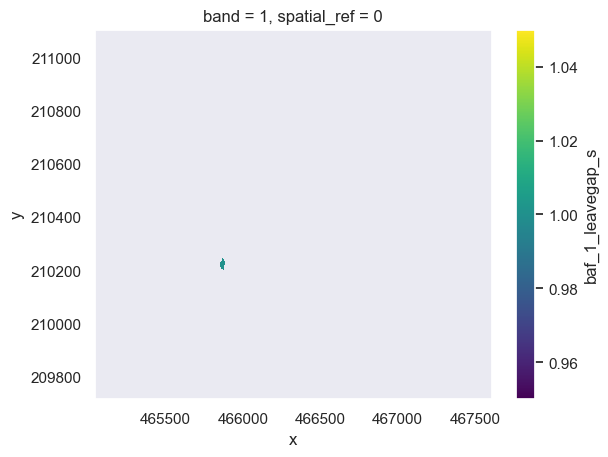

In [15]:
ds['baf_1_leavegap_s'].plot()

In [16]:
# Calculate the total area for the BAF polygons on each side of the ridge, and put into a single dataframe 
polygon_total_area_m = pd.DataFrame({'baf 1 leavegap south': ds['baf_1_leavegap_s'].count().values,
                                    'baf 17 south': ds['baf_17_s'].count().values,
                                    'baf 30 south': ds['baf_30_s'].count().values,
                                    'baf 60 south': ds['baf_60_s'].count().values,
                                    'baf 69 south': ds['baf_69_s'].count().values,
                                    'baf 80 south': ds['baf_80_s'].count().values,
                                    'baf 90 south': ds['baf_90_s'].count().values,
                                    'baf 140 south': ds['baf_140_s'].count().values,
                                    'baf 155 south': ds['baf_155_s'].count().values,
                                    'baf 2 leaveforest south': ds['baf_2_leaveforest_s'].count().values,
                                    'baf 1 leavegap north': ds['baf_1_leavegap_n'].count().values, 
                                    'baf 32 north': ds['baf_32_n'].count().values,
                                    'baf 38 north': ds['baf_38_n'].count().values,
                                    'baf 60 north': ds['baf_60_n'].count().values,
                                    'baf 82 north': ds['baf_82_n'].count().values,
                                    'baf 140 north': ds['baf_140_n'].count().values,
                                    'baf 150 leaveforest north': ds['baf_150_leaveforest_n'].count().values}, index=[0])

polygon_total_area_m # in m2

,baf 1 leavegap south,baf 17 south,baf 30 south,baf 60 south,baf 69 south,baf 80 south,baf 90 south,baf 140 south,baf 155 south,baf 2 leaveforest south,baf 1 leavegap north,baf 32 north,baf 38 north,baf 60 north,baf 82 north,baf 140 north,baf 150 leaveforest north
0,1040,3592,4479,1779,216957,1917,1895,1817,1209,876,4872,40991,38794,11624,41905,3947,2858


In [17]:
# convert to km2 
polygon_total_area_km = polygon_total_area_m/1000000
polygon_total_area_km

,baf 1 leavegap south,baf 17 south,baf 30 south,baf 60 south,baf 69 south,baf 80 south,baf 90 south,baf 140 south,baf 155 south,baf 2 leaveforest south,baf 1 leavegap north,baf 32 north,baf 38 north,baf 60 north,baf 82 north,baf 140 north,baf 150 leaveforest north
0,0.00104,0.003592,0.004479,0.001779,0.216957,0.001917,0.001895,0.001817,0.001209,0.000876,0.004872,0.040991,0.038794,0.011624,0.041905,0.003947,0.002858


In [18]:
# convert from m2 to acre 
polygon_total_area_acre = polygon_total_area_m/4046.86

# with only 3 significant figures 
polygon_total_area_acre = polygon_total_area_acre.round(2)
polygon_total_area_acre

,baf 1 leavegap south,baf 17 south,baf 30 south,baf 60 south,baf 69 south,baf 80 south,baf 90 south,baf 140 south,baf 155 south,baf 2 leaveforest south,baf 1 leavegap north,baf 32 north,baf 38 north,baf 60 north,baf 82 north,baf 140 north,baf 150 leaveforest north
0,0.26,0.89,1.11,0.44,53.61,0.47,0.47,0.45,0.3,0.22,1.2,10.13,9.59,2.87,10.35,0.98,0.71
